# 🚛 Transportation Problem Optimizer
This notebook implements the complete workflow for solving the Transportation Problem using Linear Programming (via PuLP), as implemented in `optimizer.py` and exposed through the Streamlit app.

### Covered Steps:
- Data Loading
- EDA
- Data Cleaning & Validation
- Model Definition (Linear Programming)
- Result Summary & Cost
- Save Optimized Plan

In [2]:
!pip install pulp

  Obtaining dependency information for pulp from https://files.pythonhosted.org/packages/84/45/2bb878df73b5545405faff0b0b30f72929222356387a41b50ca268951d5d/pulp-3.2.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   - -------------------------------------- 0.4/16.4 MB 8.7 MB/s eta 0:00:02
   - -------------------------------------- 0.8/16.4 MB 8.1 MB/s eta 0:00:02
   --- ------------------------------------ 1.4/16.4 MB 9.9 MB/s eta 0:00:02
   --- ------------------------------------ 1.6/16.4 MB 9.0 MB/s eta 0:00:02
   ----- ---------------------------------- 2.3/16.4 MB 9.9 MB/s eta 0:00:02
   ------ --------------------------------- 2.8/16.4 MB 9.9 MB/s eta 0:00:02
   ------- -------------------------------- 3.2/16.4 MB 9.8 MB/s eta 0:00:02
   --------- ------------------------------ 3.7/16.4 MB 9.8 MB/s eta 0:00:02
   ---------- ----------------------------- 4.2/16.4 MB 9.8 MB/s eta 0:00:02
   ----------- ---------------------------- 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp

## Step 1: Load Cost, Supply, and Demand Data

In [4]:
# File paths
cost_path = '../data/raw/cost_matrix.csv'
supply_path = '../data/raw/supply.csv'
demand_path = '../data/raw/demand.csv'

# Load data
cost_df = pd.read_csv(cost_path, index_col=0)
supply = pd.read_csv(supply_path, index_col=0).squeeze()
demand = pd.read_csv(demand_path, index_col=0).squeeze()

cost_df.head()

,Store_A,Store_B,Store_C
Warehouse_1,2,5,5
Warehouse_2,3,4,6
Warehouse_3,1,8,8
Warehouse_4,4,6,2
Warehouse_5,5,7,3


## Step 2: Exploratory Data Analysis

In [5]:
# Basic stats
display(cost_df.describe())
display(supply.describe())
display(demand.describe())

,Store_A,Store_B,Store_C
count,10.000000,10.000000,10.000000
mean,4.100000,5.000000,5.400000
std,2.330951,2.581989,2.716207
min,1.000000,1.000000,1.000000
25%,2.250000,3.250000,3.500000
50%,3.500000,5.000000,5.500000
75%,5.750000,6.750000,7.750000
max,8.000000,9.000000,9.000000


count     10.000000
mean     135.000000
std       30.276504
min       90.000000
25%      112.500000
50%      135.000000
75%      157.500000
max      180.000000
Name: 0, dtype: float64

count      9.000000
mean     132.222222
std       31.928740
min      100.000000
25%      110.000000
50%      120.000000
75%      150.000000
max      200.000000
Name: 0, dtype: float64

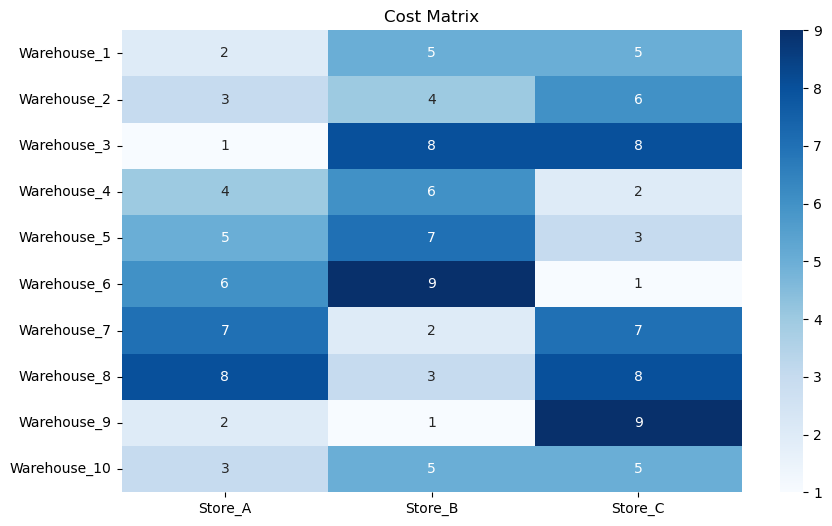

In [6]:
# Heatmap of cost matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cost_df, annot=True, fmt='.0f', cmap='Blues')
plt.title('Cost Matrix')
plt.show()

## Step 3: Data Cleaning & Preprocessing

In [7]:
# Check for missing values
display(cost_df.isnull().sum())
display(supply.isnull().sum())
display(demand.isnull().sum())

# Fill or drop nulls if necessary
cost_df.fillna(0, inplace=True)

Store_A    0
Store_B    0
Store_C    0
dtype: int64

0

0

## Step 4: Solve Transportation Problem using Linear Programming

In [8]:
def solve_transportation_problem(cost_df, supply, demand):
    warehouses = cost_df.index
    stores = cost_df.columns

    prob = pulp.LpProblem("Transportation_Problem", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("route", (warehouses, stores), lowBound=0, cat="Continuous")

    # Objective function
    prob += pulp.lpSum(cost_df.loc[w][s] * x[w][s] for w in warehouses for s in stores)

    # Supply constraints
    for w in warehouses:
        prob += pulp.lpSum(x[w][s] for s in stores) <= supply[w], f"Supply_{w}"

    # Demand constraints
    for s in stores:
        prob += pulp.lpSum(x[w][s] for w in warehouses) >= demand[s], f"Demand_{s}"

    prob.solve()

    result = pd.DataFrame(index=warehouses, columns=stores)
    for w in warehouses:
        for s in stores:
            result.loc[w, s] = x[w][s].varValue

    total_cost = pulp.value(prob.objective)
    return result.fillna(0), total_cost

result_df, total_cost = solve_transportation_problem(cost_df, supply, demand)
result_df.head()

,Store_A,Store_B,Store_C
Warehouse_1,50.0,0.0,0.0
Warehouse_2,0.0,0.0,0.0
Warehouse_3,100.0,0.0,0.0
Warehouse_4,0.0,0.0,20.0
Warehouse_5,0.0,0.0,0.0


## Step 5: Validate and Interpret Results

In [9]:
print(f"Total Transportation Cost: {total_cost:.2f}")
display(result_df)

Total Transportation Cost: 470.00


,Store_A,Store_B,Store_C
Warehouse_1,50.0,0.0,0.0
Warehouse_2,0.0,0.0,0.0
Warehouse_3,100.0,0.0,0.0
Warehouse_4,0.0,0.0,20.0
Warehouse_5,0.0,0.0,0.0
Warehouse_6,0.0,0.0,130.0
Warehouse_7,0.0,0.0,0.0
Warehouse_8,0.0,0.0,0.0
Warehouse_9,0.0,100.0,0.0
Warehouse_10,0.0,0.0,0.0


## Step 6: Save Optimized Transportation Plan

In [11]:
import os
output_path = '../data/processed/transport_plan.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
result_df.to_csv(output_path)
print(f"Saved to {output_path}")

Saved to ../data/processed/transport_plan.csv
